# Main Thesis Topic: “Zero-shot classification of ECG signals using CLIP-like model”.

**For example: Train on PBT-XL:**

- Text Encoder: ClinicalBERT (trained on diagnoses of ECG signal to obtain corresponding embeddings)
- Image Encoder: 1D-CNN (used to encode ECG signal to obtain signal embeddings)

- Experiment A): Baseline: We can take only the name of the class. For example, take “Myocardial Infarction” as a text. We should exclude some classes from training and after training is completed, the CLIP-like model can be tested on these excluded classes.
    - Next, we get embeddings of text from ClinicalBERT and train the ECG encoder with contrastive loss.

- Experiment B): Same as Experiment A but instead of testing on the same dataset/classes, we would test on other datasets containing different classes.

**Evaluation metrics:**
- Main: AUC-ROC, average_precison_score,
- Optional: Specificity, Sensitivity, F1-score

**Outcome:**
- It’s possible to train CLIP-like models with freezed (or unchanged/not fine tuned for downstream tasks) text encoder
- Training ECG encoders that are viable for representing different domains (within ECG modality) and previously unseen classes.
- Training a CLIP-like model on ECGs has little novelty.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random
from tqdm import tqdm
from scipy.signal import resample
import torch
from transformers import AutoTokenizer, AutoModel
import ast
import scipy.io as sio
from torch.utils.data import random_split
from torch.nn.functional import cosine_similarity
from scipy import signal

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [5]:
from helper_functions import *

Using the ```PhysioNet_PATH```, we can create separate datasets for training, testing & validation.

# Stage 1: Data Preprocessing

- train_set (train & validation data)
- test_set (test data)

First, let's load the SNOWMED-CT mappings:

In [6]:
smowmed_mappings_path = convert_to_forward_slashes(r'C:\Users\navme\Desktop\ECG_Project\Data\SNOWMED-CT Codes\combined_mappings.csv')

# Load the SNOMED-CT mappings
smowmed_mappings = pd.read_csv(smowmed_mappings_path)
smowmed_mappings.head(2)

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN


In [7]:
# Select the 'Dx' and 'SNOMEDCTCode' columns
codes = smowmed_mappings[['Dx', 'SNOMEDCTCode']]

# Set 'SNOWMEDCTCode' as the index
codes.set_index('SNOMEDCTCode', inplace=True)

# Convert the DataFrame into a dictionary
codes_dict = codes['Dx'].to_dict()

In [8]:
list(codes_dict.items())[:5]

[(164889003, 'atrial fibrillation'),
 (164890007, 'atrial flutter'),
 (6374002, 'bundle branch block'),
 (426627000, 'bradycardia'),
 (733534002, 'complete left bundle branch block')]

# Updated PhysioNetDataset Class 

- Update the ```PhysioNetDataset``` class such that instead of header_info --> return header_info['Dx']. Then convert the Dx code to string input for TextEncoder(). 

In [9]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')

                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def resample_ecg(self, ecg, new_length=1280):
        # Get the current length of the ECG
        current_length = ecg.shape[1]

        # Resample the ECG
        resampled_ecg = resample(ecg, new_length, axis=1)

        return resampled_ecg

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()

        dx_modalities = None
        # Parse header information
        for line in lines:
            if line.startswith('# Dx:'):
                dx_codes = line.split(':')[1].strip().split(',')
                dx_modalities = [codes_dict.get(int(code.strip()), code.strip()) for code in dx_codes]

        # 2. Get .mat file
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            mat_data = sio.loadmat(mat_file_path)

            # Extract the ECG data
            twelve_lead_ecg = mat_data['val']

            # Resample the ECG if it is not None
            twelve_lead_ecg = self.resample_ecg(twelve_lead_ecg)
            
        else:
            print(f"MAT file for index {index} does not exist.")

        # Return list of diagnoses and the np array of the 12-lead ECG
        return dx_modalities, twelve_lead_ecg


    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

        for i, ax in enumerate(axs.flat):
            ax.plot(data['val'][i], linewidth=0.5)
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

In [10]:
# Path to training folder within PhysioNet dataset
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [11]:
train_set = PhysioNetDataset(PhysioNet_PATH, train=True)
test_set = PhysioNetDataset(PhysioNet_PATH, train=False)
len(train_set), len(test_set)

(65900, 22352)

The ```train_set``` can be split into ```current_train``` (85%) and ```current_val``` (15%).

In [12]:
# Set the seed for the random number generator
torch.manual_seed(0)

# Get the length of the train_set
length = len(train_set)

# Calculate the lengths of the splits
train_length = int(0.85 * length)
val_length = length - train_length

# Split the dataset
current_train, current_val = random_split(train_set, [train_length, val_length])

In [13]:
len(current_train), len(current_val)

(56015, 9885)

In [14]:
# Diagnoses
current_train[0][0]

['sinus tachycardia',
 't wave inversion',
 't wave abnormal',
 'prolonged qt interval']

In [15]:
# 12-lead ECG (np array)
current_train[0][1]

array([[-71.34097139, -66.61618625, -70.0758572 , ..., -52.92145257,
        -59.69901109, -73.16815791],
       [-31.59670027, -28.05956272, -30.40064515, ..., -17.67892896,
        -22.51437818, -29.22333363],
       [ 39.59967924,  38.58499099,  39.66795185, ...,  35.07206841,
         37.2502028 ,  43.02494519],
       ...,
       [ 69.88955802,  24.5637892 ,  52.41854568, ..., 106.78796002,
        102.79795509, 137.64734616],
       [ 63.90011689,  -3.02341535,  14.90178861, ..., 150.59374912,
        139.59818744, 164.26619786],
       [-19.09647781, -47.44984823, -61.35651896, ...,  -1.97052429,
         -7.0484108 ,   8.76181162]])

In [16]:
print("There are {} leads in the ECG.".format(current_train[0][1].shape[0]))

There are 12 leads in the ECG.


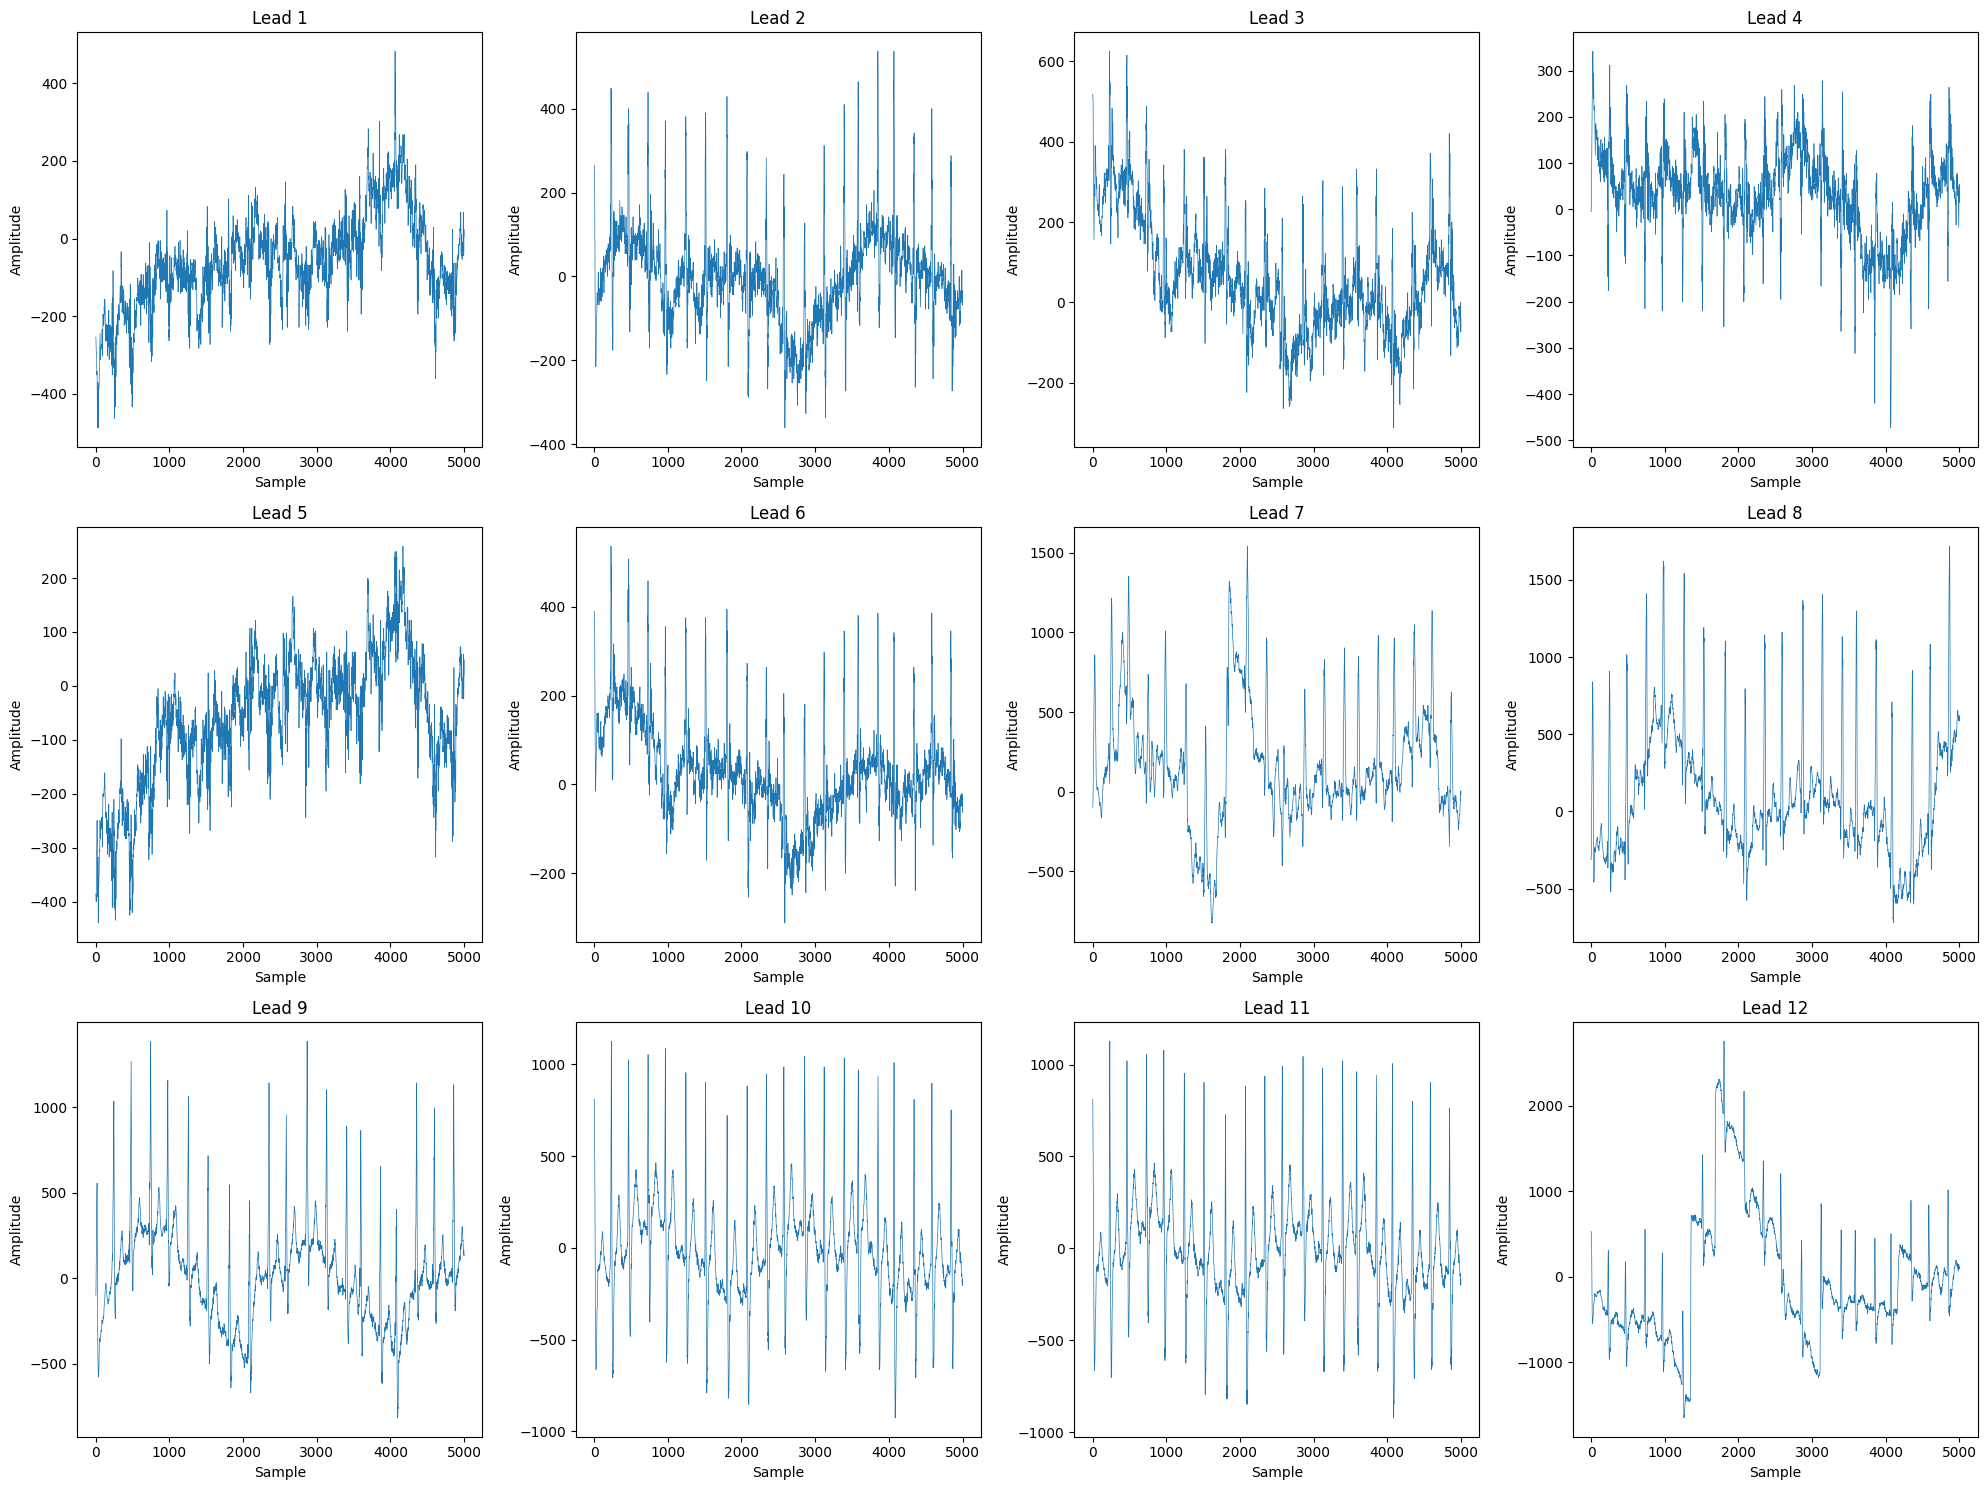

In [17]:
train_set.plot_record(0)

# Stage 2: ECG Classification Model Pipeline

Now that our data is preprocessed, we can begin working on the Model Pipeline itself. The ECG Classification Model Pipeline will consist of three components:

1. `TextEncoder()` class

2. `ECGEncoder()` class

3. `InstanceSelector()` class

4. `CLIPModel()` class

An overview and outline of each of these components can be found below in their respective subsections.

## TextEncoder()

Create a class, ```TextEncoder()``` that is used to convert the description of the (dx_modality) diagnosis class into embeddings using the ClinicalBERT model.

- Input should be a concatenated using comma or blank space string of diagnoses/dx_modality per ECG signal.
- Use processed CSV files (dx_modality vs dx_modality, age, etc together)
- Frozen weights (since it's already pretrained)

In [18]:
class TextEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(self.device)

        # Add embed_dim attribute
        self.embed_dim = self.model.config.hidden_size


    def encode(self, text_list):
        # Check if text_list is a string representation of a list
        if isinstance(text_list, str):
            text_list = ast.literal_eval(text_list)
        # Convert list of strings to a single string
        text = ', '.join(text_list)
        # Tokenize text
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Move inputs to the correct device
        inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
        # Get embeddings from ClinicalBERT model
        with torch.no_grad():
            embeddings = self.model(**inputs).last_hidden_state
        # Average the embeddings to get single vector per each input
        embeddings = torch.mean(embeddings, dim=1)
        return embeddings.to(self.device)

## ECGEncoder()

- Input is ECG signal, output will be embeddings of ECG signal
- This is going to be model in model.py
- Model weights are updated iteratively
- optimizer = torch.optim.Adam(clip_model.ECGEncoder.parameters())

**Current Tasks:**

- Change number of layers of fully connected layer 2 to 768 out_channels
- Alternatively look into getting rid of the second fully connected layer. 
- Shifting from 128 --> 768 can cause loss of information. 
- Update all layers after layer 7 as follows:  
    - ```self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)```
    - ```self.bn7 = nn.BatchNorm1d(512)```


In [19]:
class ECGEncoder(nn.Module):
    def __init__(self):
        super(ECGEncoder, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 5
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 6
        self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 7
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 8
        self.conv8 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm1d(512)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 9
        self.conv9 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm1d(512)
        self.relu9 = nn.ReLU()
        self.pool9 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 10
        self.conv10 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm1d(512)
        self.relu10 = nn.ReLU()
        self.pool10 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Fully Connected Layer 1
        # self.fc1 = nn.Linear(512*4, 768)
        self.relu11 = nn.ReLU()

        # Add embed_dim attribute
        self.embed_dim = 768

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        # Layer 7
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.pool7(x)

        # Layer 8
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        # Layer 9
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = self.pool9(x)

        # Layer 10
        x = self.conv10(x)
        x = self.bn10(x)
        x = self.relu10(x)
        x = self.pool10(x)

        # Flatten the output of the convolutional layers
        print(x.size())
        x = x.view(x.size(0), -1)

        # Initialize self.fc1 here, using the size of x
        if not hasattr(self, 'fc1'):
            self.fc1 = nn.Linear(x.size(1), self.embed_dim).to(x.device)
        x = self.fc1(x)
        x = self.relu11(x) 

        return x 

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
# Instantiate the model
model = ECGEncoder()

# Convert the numpy array to a PyTorch tensor
input_data = torch.from_numpy(current_train[0][1]).float()

# Add an extra dimension to the tensor to represent the batch size
input_data = input_data.unsqueeze(0)

# Pass the tensor through the model
output = model(input_data)

# Print the output
print(output)

torch.Size([1, 512, 1])
tensor([[2.8303e-01, 0.0000e+00, 2.4950e-01, 5.0951e-05, 1.6705e-01, 6.8866e-01,
         2.2919e-01, 0.0000e+00, 9.9723e-02, 4.9532e-02, 1.2515e-01, 1.6464e-01,
         0.0000e+00, 2.5692e-01, 0.0000e+00, 0.0000e+00, 2.6533e-01, 0.0000e+00,
         2.9730e-01, 3.4203e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7445e-02,
         0.0000e+00, 0.0000e+00, 2.5027e-01, 0.0000e+00, 1.1129e-01, 0.0000e+00,
         4.3507e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.6030e-01, 2.2731e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.3510e-01, 0.0000e+00, 0.0000e+00, 2.4427e-02, 3.4493e-01, 0.0000e+00,
         3.0785e-01, 0.0000e+00, 2.2657e-01, 5.0581e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.3567e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         6.4651e-02, 0.0000e+00, 0.0000e+00, 3.6677e-01, 0.0000e+00, 0.0000e+00,
         1.1838e-01, 0.0000e+00, 4.1070e-01, 1.2233e-01, 1.2302e-01, 0.0000e+00,
    

In [22]:
# Count the parameters
num_params = count_parameters(model)
print(f'The model has {num_params} trainable parameters')

The model has 4073232 trainable parameters


In [23]:
# Set the model to evaluation mode
model.eval()

# Pass the data through the model
output = model(input_data)

print(type(output))

torch.Size([1, 512, 1])
<class 'torch.Tensor'>


## CLIPModel

The final component of the Model Pipeline is to create a `ClIPModel` class which takes `TextEncoder` and `ECGEncoder` to train the final model with contrastive loss. 

```
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
Figure 3. Numpy-like pseudocode for the core of an implementation of CLIP
```

In [24]:
class CLIPModel(nn.Module):
    def __init__(self, text_encoder, ecg_encoder, embed_dim, temperature):
        super(CLIPModel, self).__init__()
        self.text_encoder = text_encoder
        self.ecg_encoder = ecg_encoder
        self.temperature = temperature
        self.W_i = nn.Linear(ecg_encoder.embed_dim, embed_dim)
        self.W_t = nn.Linear(text_encoder.embed_dim, embed_dim)

    def forward(self, ecgs, texts):
        # Extract feature representations of each modality
        I_f = self.ecg_encoder(ecgs)  # [n, d_i]
        T_f = torch.stack([self.text_encoder.encode(text).squeeze() for text in texts])  # [n, d_t]

        # Joint multimodal embedding [n, d_e]
        I_e = F.normalize(self.W_i(I_f), dim=1)
        T_e = F.normalize(self.W_t(T_f), dim=1)

        # print(f"I_e shape: {I_e.shape}")
        # print(f"T_e shape: {T_e.shape}")

        # Scaled pairwise cosine similarities [n, n]
        logits = torch.matmul(I_e, T_e.t()) / self.temperature

        # Symmetric loss function
        labels = torch.arange(len(ecgs)).to(ecgs.device)
        loss_i = F.cross_entropy(logits, labels)
        loss_t = F.cross_entropy(logits.t(), labels)
        loss = (loss_i + loss_t) / 2

        return loss

Let's break down this `CLIPModel` class:

- `__init__` method: This is the constructor for the `CLIPModel` class. It initializes the text and ECG encoders, the temperature for the softmax function, and two linear layers (`W_i` and `W_t`). The linear layers are used to transform the embeddings produced by the encoders to a common embedding space. The `embed_dim` parameter determines the dimensionality of this common space.

- `forward` method: This is the method that is called when you pass data through the model.

    - `I_f = self.ecg_encoder(ecgs)`: This line passes the ECG data through the ECG encoder to get a feature representation (`I_f`).

    - `T_f = torch.stack([self.text_encoder.encode(text).squeeze() for text in texts])`: This line encodes each text in the `texts` list using the text encoder, squeezes the output to remove any unnecessary dimensions, and stacks the results into a tensor (`T_f`).

    - `I_e = F.normalize(self.W_i(I_f), dim=1)` and `T_e = F.normalize(self.W_t(T_f), dim=1)`: These lines pass the feature representations through the linear layers (`W_i` and `W_t`), and then normalize the output. The result (`I_e` and `T_e`) are the embeddings in the common space.

    - `logits = torch.matmul(I_e, T_e.t()) / self.temperature`: This line computes the cosine similarity between the ECG and text embeddings, scales it by the temperature, and stores the result in `logits`.

    - The last few lines compute the cross-entropy loss between the logits and the labels (which are just the indices of the data points). The loss is computed twice: once for the ECG-to-text direction (`loss_i`), and once for the text-to-ECG direction (`loss_t`). The final loss is the average of these two losses.

In summary, `W_i` and `W_t` are used to transform the feature representations produced by the encoders into a common embedding space. The model then computes the similarity between the ECG and text embeddings in this common space, and uses this to compute the loss.

In [32]:
# Instantiate the encoders
text_encoder = TextEncoder()
ecg_encoder = ECGEncoder()

# Instantiate the encoders and the model
CLIP_model = CLIPModel(text_encoder, ecg_encoder, embed_dim=512, temperature=1)

In [ ]:
def resample_ecg(ecg, new_length=1280):
    # Get the current length of the ECG
    current_length = ecg.shape[1]

    # Resample the ECG
    resampled_ecg = signal.resample(ecg, new_length, axis=1)

    return resampled_ecg

In [ ]:
# Generate 50 random indices
indices = random.sample(range(len(current_train)), 750)

# Extract the samples at these indices
texts = [current_train[i][0] for i in indices]
ecgs = [current_train[i][1] for i in indices]

# Convert the list of numpy arrays to a tensor
ecgs_tensor = torch.stack([torch.from_numpy(ecg).float() for ecg in ecgs])

In [ ]:
len(ecgs_tensor), len(ecgs), len(ecgs[0])

In [ ]:
current_train[0][1]

In [ ]:
# Pass the tensor and texts through the model
loss = CLIP_model(ecgs_tensor, texts)

# Print the loss
print(loss)

# Model Training

## DataLoaders + Setup

In [1]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
# Instantiate the encoders
text_encoder = TextEncoder(device).to(torch.device("cuda"))
ecg_encoder = ECGEncoder().to(torch.device("cuda"))

# Instantiate the encoders and the model
CLIP_model = CLIPModel(text_encoder, ecg_encoder, embed_dim=512, temperature=1)

In [ ]:
# Parameters
lr = 0.001
weight_decay = 0.01
optimizer = torch.optim.Adam(CLIP_model.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 3

## Training CLIP model on ```current_train```

In [ ]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    ecgs = [item[1] for item in batch]
    # Pad the sequences
    ecgs_padded = pad_sequence([torch.from_numpy(ecg) for ecg in ecgs], batch_first=True)
    return texts, ecgs_padded

# In your DataLoader, specify the collate_fn
current_train_loader = DataLoader(current_train, batch_size=64, collate_fn=collate_fn)

In [ ]:
def train_model(model, optimizer, num_epochs, device):
    # Move model to the device
    CLIP_model.to(device)

    # Store the losses for each epoch
    losses = []

    for epoch in range(num_epochs):
        CLIP_model.train()  # Set the model to training mode
        running_loss = 0.0
        pbar = tqdm(enumerate(current_train_loader, 0), total=len(current_train_loader), leave=False)
        
        # Then in your training loop
        for i, data in pbar:
            # Extract the samples
            texts = data[0]  # Move texts to the device
            ecgs = data[1].float().to(device)  # ecgs is already a tensor, just move it to the device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Pass the tensor and texts through the model
            loss = CLIP_model(ecgs, texts)  # Pass the tensor directly

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1} Loss: {running_loss/(i+1):.4f}")
        epoch_loss = running_loss / len(current_train)
        losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

    return CLIP_model, losses

In [ ]:
train_model(CLIP_model, optimizer, num_epochs, device)

## Evaluating CLIP model on ```current_val```

## Testing Trained CLIP model on ```test_set```

In [ ]:
# Pseudo Code
def predict_diagnosis(CLIP_model, ecg_sample, all_diagnoses):
    # Generate the ECG embedding
    ecg_embedding = CLIP_model.ecg_encoder(ecg_sample)

    # Generate embeddings for all possible diagnoses
    diagnosis_embeddings = [CLIP_model.text_encoder.encode(diagnosis) for diagnosis in all_diagnoses]

    # Calculate the similarity between the ECG embedding and each diagnosis embedding
    similarities = [torch.dot(ecg_embedding, diagnosis_embedding) for diagnosis_embedding in diagnosis_embeddings]

    # The predicted diagnosis is the one with the highest similarity
    predicted_diagnosis = all_diagnoses[torch.argmax(similarities)]

    return predicted_diagnosis